# Credit Default Risk

Este notebook serve para fazer os exercícios do livro Projetos de Ciência de Dados com Python, especificamente do capítulo 2 - Exploração e Limpeza de dados


**O desafio da empresa**

A empresa de cartão de crédito disponibilizou um dataset com dados demográficos e financeiros dos últimos 6 meses de uma amostra de 30.000 titulares de contas. Há uma linha para cada conta e as linhas são rotuladas de acordo com se no mês seguinte ao período de dados histórico de seis meses um proprietário de conta ficou inadimplente, ou seja, não fez o pagamento mínimo

**Objetivo**

Desenvolver um algoritmo que consiga prever se uma conta ficará inadimplente no próximo mês com base no conjunto de dados.


# Dicionário dos Dados



| **Coluna**     | **Descrição**                                                                                                                                       |
|----------------|-------------------------------------------------------------------------------------------------------------------------------------------------------|
| **LIMIT_BAL**  | Montante do crédito concedido (em dólar taiwanês): inclui tanto o crédito individual do consumidor quanto o crédito da sua família (suplementar).     |
| **SEX**        | Gênero (1 = masculino; 2 = feminino). **Nota:** Não usarei os dados de gênero para tomar decisões devido a considerações éticas.                     |
| **EDUCATION**  | Educação (1 = pós-graduação; 2 = universidade; 3 = ensino médio; 4 = outros).                                                                        |
| **MARRIAGE**   | Estado civil (1 = casado; 2 = solteiro; 3 = outros).                                                                                                 |
| **AGE**        | Idade (anos).                                                                                                                                        |
| **PAY_1-PAY_6**| Histórico de pagamento passado. Foram rastreados os registros mensais de pagamento passado (de abril a setembro de 2005) da seguinte forma: <br> PAY_1 = status de pagamento em setembro de 2005; <br> PAY_2 = status de pagamento em agosto de 2005; <br> ...; PAY_6 = status de pagamento em abril de 2005. <br> A escala de medição para o status de pagamento é: <br> -1 = pago pontualmente; 1 = atraso de pagamento por um mês; <br> 2 = atraso de pagamento por dois meses; ...; <br> 8 = atraso de pagamento por oito meses; 9 = atraso de pagamento por nove meses ou mais. |
| **BILL_AMT1-BILL_AMT6** | Valor da fatura (em dólar taiwanês). <br> BILL_AMT1 representa o valor da fatura em setembro; <br> BILL_AMT2 representa o valor da fatura em agosto; <br> e assim por diante até BILL_AMT7, que representa o valor pago em abril. |
| **Explicações adicionais das colunas feitas pelo sócio da empresa** | -2: Significa que começou o mês sem valor a ser pago e o crédito não foi usado. <br> -1: Significa que usou um valor que foi totalmente pago. <br> 0: Significa que o pagamento mínimo foi feito, mas o saldo total devedor não foi pago. |

# 0.0 IMPORTS

In [39]:
# Import Libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.linear_model import LogisticRegression

# Display options.
pd.set_option('display.max_columns', None)


## 0.1 Loading data

In [40]:
URL = 'https://github.com/TrainingByPackt/Data-Science-Projects-with-Python/raw/master/Data/Chapter_1_cleaned_data.csv'
df = pd.read_csv( URL )

# Chapter 3: Detalhes da regressão logística e exploração das características

## Fature Selection

In [41]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'EDUCATION_CAT', 'graduate school',
       'high school', 'none', 'others', 'university'],
      dtype='object')

In [42]:
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                   'PAY_6', 'EDUCATION_CAT', 'graduate school', 'high school',
                   'none', 'others', 'university']

In [43]:
# List comprehension
features_response = [col for col in df.columns if col not in items_to_remove]

In [44]:
# Calculando corr linear ou de pearson
corr = df[features_response].corr()
corr.iloc[0:5, 0:5]

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_1
LIMIT_BAL,1.000000,-0.232688,-0.111873,0.149157,-0.273396
EDUCATION,-0.232688,1.000000,-0.137097,0.179035,0.112653
MARRIAGE,-0.111873,-0.137097,1.000000,-0.412828,0.019759
AGE,0.149157,0.179035,-0.412828,1.000000,-0.044277
PAY_1,-0.273396,0.112653,0.019759,-0.044277,1.000000


<Axes: >

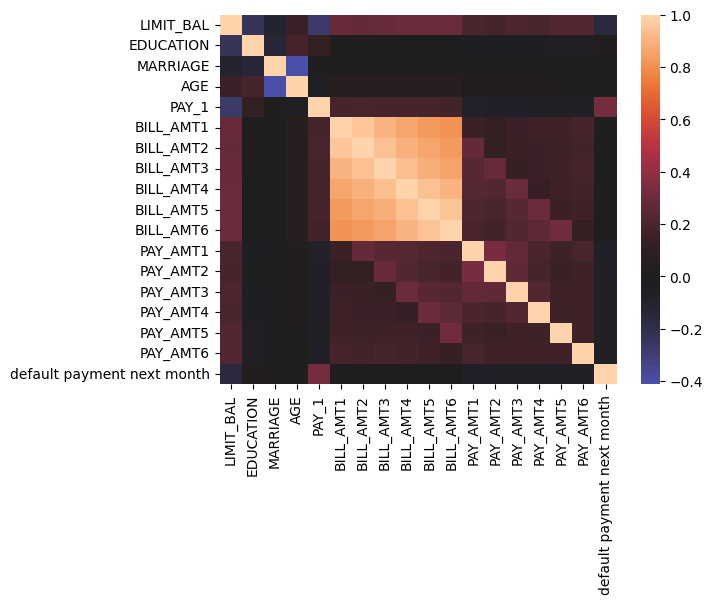

In [45]:
sns.heatmap( corr,
              xticklabels=corr.columns.values,
              yticklabels=corr.columns.values,
              center=0)

PAY_1 é a mais fortemente correlacionada com a variável resposta

## Exercício 11: Teste F e seleção de características univariada

A correlação linear é interessante, mas não foi feita para comparar features contínuas c/ categóricas. Então vamos explorar outra técnica

In [64]:
TARGET_NAME = 'default payment next month'

X = df[features_response].drop(columns=[TARGET_NAME]).values
y = df[TARGET_NAME].values

In [47]:
from sklearn.feature_selection import f_classif

In [48]:
[f_stat, f_p_value] = f_classif( X, y )

In [49]:
# Teste F ANOVA
f_test_df = pd.DataFrame({'Feature': features_response[:-1],
                          'F statistic':f_stat,
                          'p value':f_p_value})
f_test_df.sort_values( 'p value' )

,Feature,F statistic,p value
4,PAY_1,3156.672300,0.000000e+00
0,LIMIT_BAL,651.324071,5.838366e-142
11,PAY_AMT1,140.612679,2.358354e-32
12,PAY_AMT2,101.408321,8.256124e-24
13,PAY_AMT3,90.023873,2.542641e-21
15,PAY_AMT5,85.843295,2.090120e-20
16,PAY_AMT6,80.420784,3.219565e-19
14,PAY_AMT4,79.640021,4.774112e-19
1,EDUCATION,32.637768,1.122175e-08
2,MARRIAGE,18.078027,2.127555e-05


PAY_1 E LIMIT_BAL têm valores-p menores, o que indica que os valores da média dessas características entre a classe positiva e negativa são significativamente diferentes, e ajudarão a prever a que classe uma amostra pertence.

In [50]:
 # Selecionando as features consideradas pelo teste F como as 20% melhores
 from sklearn.feature_selection import SelectPercentile

In [51]:
selector = SelectPercentile( f_classif, percentile=20 )

In [52]:
selector.fit( X, y )

SelectPercentile(percentile=20)

In [53]:
best_feature_ix = selector.get_support()
best_feature_ix

array([ True, False, False, False,  True, False, False, False, False,
       False, False,  True,  True, False, False, False, False])

In [54]:
features = features_response[:-1]

In [55]:
# ìndice lógico das características selecionadas
best_features = [features[counter] for counter in range(len(features)) if best_feature_ix[counter]]

In [56]:
best_features = [features[counter] for counter in range(len(features))
                  if best_feature_ix[counter]]
best_features

['LIMIT_BAL', 'PAY_1', 'PAY_AMT1', 'PAY_AMT2']

## Exercício 12: Visualizando o relacionamento entre as características e a resposta

In [ ]:
overall_default_rate = df[TARGET_NAME].mean()
overall_default_rate

In [ ]:
# Visualizando as taxas de inadimplencia para diferentes valores de PAY_1
group_by_pay_mean_y = df.groupby( 'PAY_1')[TARGET_NAME].mean()

In [ ]:
# Taxa de não pagamento de dívidas para todos os lados
axes = plt.axes()
axes.axhline(overall_default_rate, color='red')
group_by_pay_mean_y.plot( marker='x', legend=False, ax=axes)
axes.set_ylabel( 'Proporção de Credit Defaults')
axes.legend(['Entire dataset', 'Groups of PAY_1'])

Os dados históricos mostram uma tendência esperada, as contas em boa situação (-2, -1, 0) possuem taxa de inadimplência abaixo da média. E as contas que já ficaram inadimplentes, tendem a repetir esse comportamento.

### LIMIT_BAL

In [69]:
pos_mask = y == 1
neg_mask = y == 0

Text(0.5, 1.0, 'Credit limits by response variable')

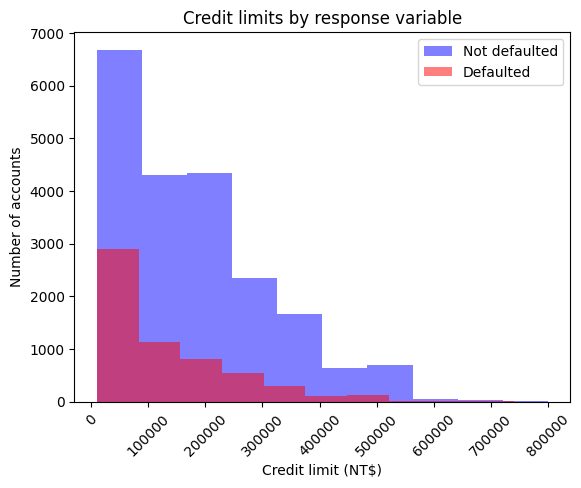

In [70]:
# Histogramas duplos dos limites de crédito
axes = plt.axes()
axes.hist(df.loc[neg_mask, 'LIMIT_BAL'], alpha=0.5, color='blue')
axes.hist(df.loc[pos_mask, 'LIMIT_BAL'], alpha=0.5, color='red')
axes.tick_params(axis='x', labelrotation=45)
axes.set_xlabel( 'Credit limit (NT$)')
axes.set_ylabel( 'Number of accounts')
axes.legend(['Not defaulted', 'Defaulted'])
axes.set_title( 'Credit limits by response variable')

Como existem mais contas not defaulted, o histograma não mostra o feito desejado. Portanto vamos normalizar. Após a normalização, a área contida dentro de cada histograma será igual a 1.

In [71]:
df['LIMIT_BAL'].max()

800000

In [72]:
# criando borda de bins
bin_edges = list(range(0,850000, 50000))
print(bin_edges[-1])

800000


<ipython-input-73-e848c5d864fd>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(np.round(y_ticks*50000,2))


Text(0.5, 1.0, 'Normalized distributions of credit limits by response variable')

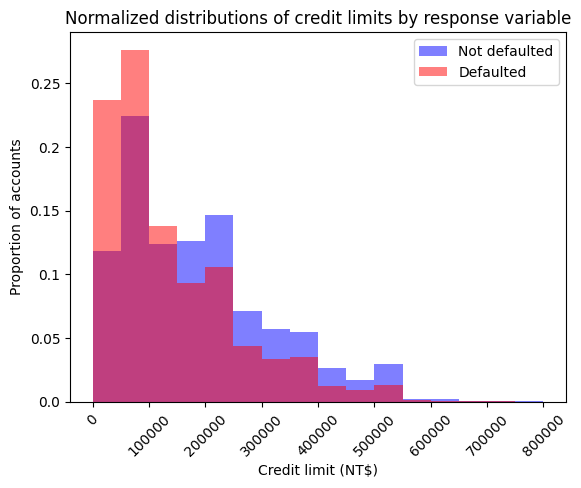

In [73]:
# Normalizando os histogramas
axes = plt.axes()
axes.hist(df.loc[neg_mask, 'LIMIT_BAL'], bins=bin_edges,
          alpha=0.5, density=True, color='blue')
axes.hist(df.loc[pos_mask, 'LIMIT_BAL'], bins=bin_edges,
          alpha=0.5, density=True, color='red')
axes.tick_params(axis='x', labelrotation=45)
axes.set_xlabel( 'Credit limit (NT$)' )
axes.set_ylabel( 'Proportion of accounts' )
y_ticks = axes.get_yticks()
axes.set_yticklabels(np.round(y_ticks*50000,2))
axes.legend(['Not defaulted', 'Defaulted'])
axes.set_title( 'Normalized distributions of credit limits by response variable')


## Entendendo a regressão logística com sintaxe de funções Python e a função Sigmóide

In [74]:
X_exp = np.linspace( -4, 4, 81 )
print( X_exp[:5])
print( X_exp[-5:])

[-4.  -3.9 -3.8 -3.7 -3.6]
[3.6 3.7 3.8 3.9 4. ]


In [75]:
Y_exp = np.exp( X_exp )


## Exercício 13: Plotando a função sigmóide

Text(0.5, 1.0, 'Plot of $e^X$')

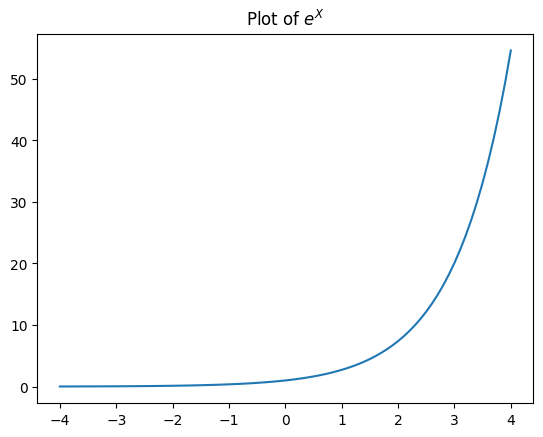

In [76]:
plt.plot( X_exp, Y_exp)
plt.title( 'Plot of $e^X$')

Text(0.5, 1.0, 'Plot of $e^{-X}$')

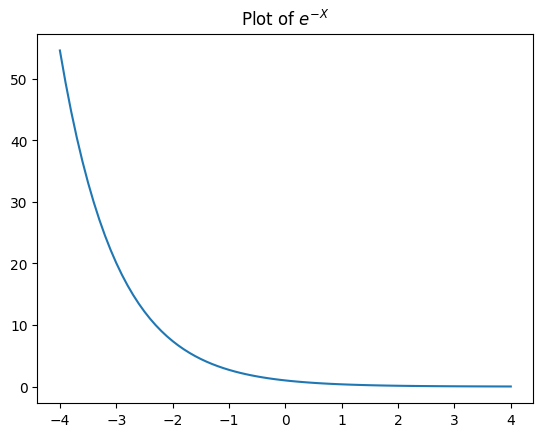

In [77]:
Y_exp = np.exp( -X_exp )
plt.plot( X_exp, Y_exp )
plt.title( 'Plot of $e^{-X}$')

In [78]:
#  R --> Número reais são convertidos em probabilidades entre 0 e 1.
def sigmoid(X):
  Y = 1 / (1 + np.exp(-X)) # Variável de escopo local
  return Y

Text(0.5, 1.0, 'The sigmoid function')

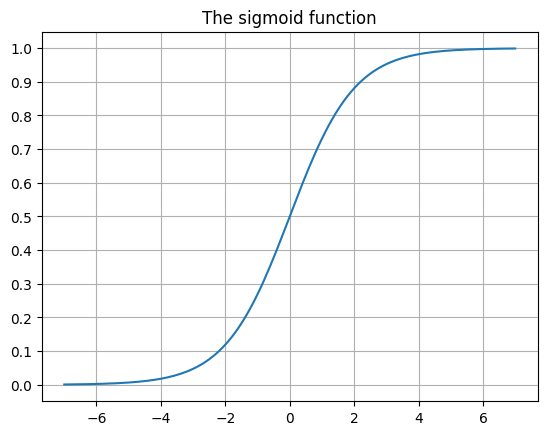

In [79]:
X_sig = np.linspace( -7, 7, 141 )
Y_sig = sigmoid( X_sig )
plt.plot(X_sig, Y_sig )
plt.yticks( np.linspace(0,1,11))
plt.grid()
plt.title( 'The sigmoid function')

In [80]:
# Escopo das funções
example_global_variable = 1

In [81]:
def example_function():
  output = example_global_variable + 1
  return (output)

In [82]:
example_function()

2

## Exercício 14: Examinando a conveniência das features para a regressão logística

In [90]:
# Probabilidades de default para valores de PAY_1
group_by_pay_mean_y

,default payment next month
PAY_1,
-2,0.131664
-1,0.170002
0,0.128295
1,0.336400
2,0.694701
3,0.773973
4,0.682540
5,0.434783
6,0.545455


In [91]:
p = group_by_pay_mean_y.values
q = 1-p
print(p)
print(q)

[0.13166397 0.17000198 0.12829525 0.33639988 0.69470143 0.7739726
 0.68253968 0.43478261 0.54545455 0.77777778 0.58823529]
[0.86833603 0.82999802 0.87170475 0.66360012 0.30529857 0.2260274
 0.31746032 0.56521739 0.45454545 0.22222222 0.41176471]


In [92]:
odds_ratio = p/q
odds_ratio

array([0.15162791, 0.20482215, 0.14717742, 0.50693161, 2.27548209,
       3.42424242, 2.15      , 0.76923077, 1.2       , 3.5       ,
       1.42857143])

In [93]:
log_odds = np.log( odds_ratio )
log_odds


array([-1.88632574, -1.58561322, -1.91611649, -0.67937918,  0.82219194,
        1.23088026,  0.76546784, -0.26236426,  0.18232156,  1.25276297,
        0.35667494])

In [94]:
group_by_pay_mean_y.index

Index([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64', name='PAY_1')

Text(0.5, 0, 'Values of PAY_1')

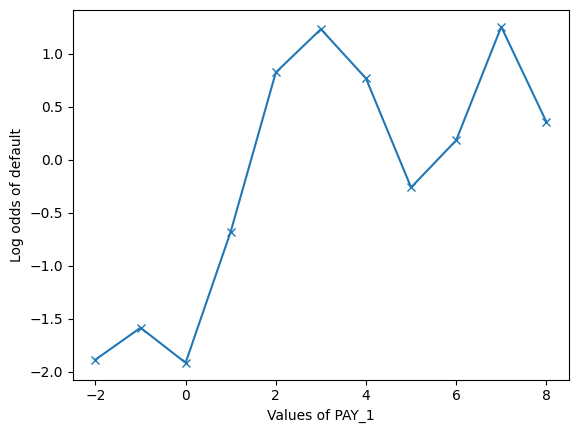

In [97]:
# logaritmo das chances de inadimplencia para  valores de PAY_1
plt.plot( group_by_pay_mean_y.index, log_odds, '-x' )
plt.ylabel( 'Log odds of default' )
plt.xlabel( 'Values of PAY_1')

## Exercício 15: Limite de decisão linear da regressão logística

In [98]:
# Gerando dados sintéticos
np.random.seed( seed=6 )
X_1_pos = np.random.uniform( low=1, high=7, size=(20,1))
print( X_1_pos[0:3])

X_1_neg = np.random.uniform( low=3, high=10, size=(20,1))
print( X_1_neg[0:3])

X_2_pos = np.random.uniform(low=1, high=7, size=(20,1))
print( X_1_pos[0:3])

X_2_neg = np.random.uniform( low=3, high=10, size=(20,1))
print( X_1_neg[0:3])

[[6.35716091]
 [2.99187883]
 [5.92737474]]
[[3.38132155]
 [8.03046066]
 [8.61519394]]
[[6.35716091]
 [2.99187883]
 [5.92737474]]
[[3.38132155]
 [8.03046066]
 [8.61519394]]


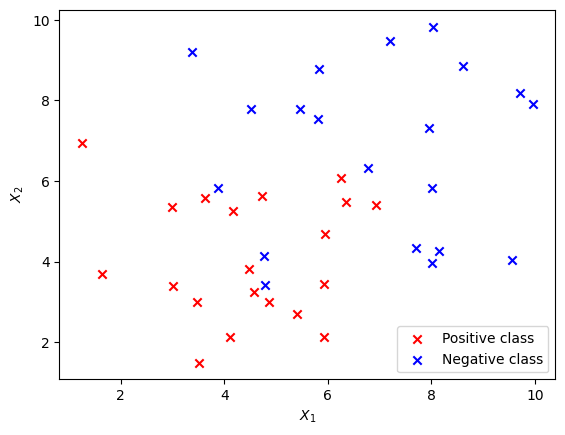

In [99]:
plt.scatter( X_1_pos, X_2_pos, color='red', marker='x')
plt.scatter( X_1_neg, X_2_neg, color='blue', marker='x')
plt.xlabel( '$X_1$' )
plt.ylabel( '$X_2$' )
plt.legend( ['Positive class', 'Negative class'])

In [100]:
# Criando matriz 40 por 2
X = np.block([[X_1_pos, X_2_pos], [X_1_neg, X_2_neg]])
print( X.shape )
print( X[0:3])

(40, 2)
[[6.35716091 5.4790643 ]
 [2.99187883 5.3444234 ]
 [5.92737474 3.43664678]]


In [103]:
y = np.vstack((np.ones((20,1)), np.zeros((20,1)))).reshape(40,)
print( y[0:5] )
print( y[-5:])

[1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0.]


In [104]:
from sklearn.linear_model import LogisticRegression

In [106]:
example_lr = LogisticRegression(solver='liblinear')
example_lr.fit(X, y)

LogisticRegression(solver='liblinear')

In [107]:
y_pred = example_lr.predict( X )
positive_indices = [counter for counter in range(len(y_pred)) if y_pred[counter]==1]
negative_indices = [counter for counter in range(len(y_pred)) if y_pred[counter]==0]
positive_indices

[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 32, 38]

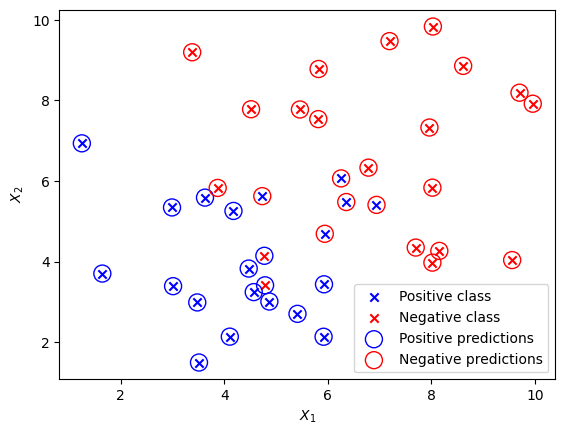

In [111]:
plt.scatter( X_1_pos, X_2_pos, color='blue', marker='x')
plt.scatter( X_1_neg, X_2_neg, color='red', marker='x')
plt.scatter(X[positive_indices, 0], X[positive_indices, 1], s=150, marker='o',
            edgecolors='blue', facecolors='none')
plt.scatter(X[negative_indices,0], X[negative_indices,1], s=150, marker='o',
            edgecolors='red', facecolors='none')
plt.xlabel( '$X_1$')
plt.ylabel( '$X_2$')
plt.legend(['Positive class', 'Negative class', 'Positive predictions', 'Negative predictions'])

In [112]:
theta_1 = example_lr.coef_[0][0]
theta_2 = example_lr.coef_[0][1]
print( theta_1, theta_2)

-0.20245058016285838 -0.25336423626773225


In [113]:
theta_0 = example_lr.intercept_

In [114]:
# Definindo o limite de decisão linear
X_1_decision_boundary = np.array([0, 10])
X_2_decision_boundary = -(theta_1/theta_2)*X_1_decision_boundary - (theta_0/theta_2)

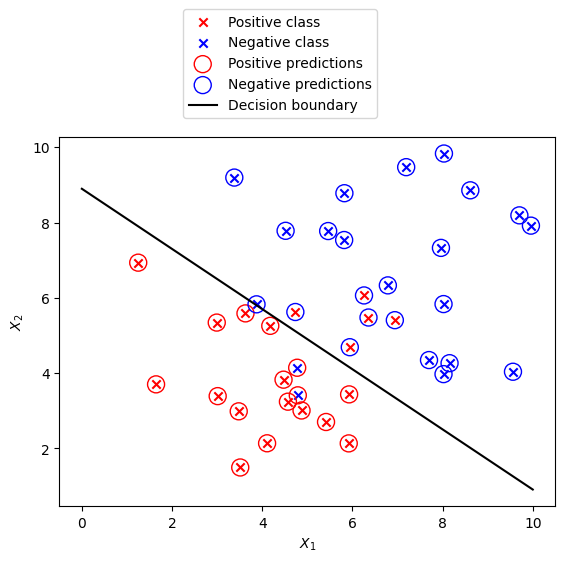

In [115]:
# Classes reais, classes previstas e o limite de decisão de uma regressão logística
pos_true = plt.scatter( X_1_pos, X_2_pos, color='red', marker='x',
                       label='Positive class')
neg_true = plt.scatter( X_1_neg, X_2_neg, color='blue', marker='x',
                       label='Negative class')
pos_pred = plt.scatter(X[positive_indices,0], X[positive_indices,1], s=150,
                       marker='o', edgecolor='red', facecolors='none', label='Positive predictions')
neg_pred = plt.scatter(X[negative_indices,0], X[negative_indices,1], s=150,
                       marker='o', edgecolors='blue', facecolors='none', label='Negative predictions')
dec = plt.plot(X_1_decision_boundary, X_2_decision_boundary, 'k-', label='Decision boundary')

plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend(loc=[0.25, 1.05])

## Atividade 3

In [118]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[['PAY_1', 'LIMIT_BAL']].values, df[TARGET_NAME].values, test_size=0.2, random_state=42)

In [125]:
model_lr = LogisticRegression(solver='liblinear')
# training
model_lr.fit( X_train, y_train )
y_pred = model_lr.predict( X_test )
y_pred_proba = model_lr.predict_proba( X_test )

In [126]:
# Extraia os coeficientes e a interceptação do modelo
ones_and_features = np.hstack([np.ones((X_test.shape[0],1)), X_test])

In [129]:
intercept_and_coefs = np.concatenate([model_lr.intercept_.reshape(1,1), model_lr.coef_], axis=1)

In [130]:
X_lin_comb = np.dot(intercept_and_coefs, np.transpose(ones_and_features))

In [132]:
y_pred_proba_manual = sigmoid(X_lin_comb)

In [133]:
y_pred_manual = y_pred_proba_manual >= 0.5

In [135]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred_proba_manual.reshape(y_pred_proba_manual.shape[1],))

0.6374912949931919

In [136]:
roc_auc_score(y_test, y_pred_proba[:,1])

0.6374912949931919